In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [2]:
class graph:
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.x_points = np.array([x])
        self.y_points = np.array([y])
        self.theta = theta

    def move_forward(self, distance):
        self.x += distance * np.cos(np.radians(self.theta))
        self.y += distance * np.sin(np.radians(self.theta))
        self.x_points = np.append(self.x_points, self.x)
        self.y_points = np.append(self.y_points, self.y)

    # Function to turn by a certain angle (degrees)
    def turn(self, degrees):
        self.theta += degrees


In [19]:

def calculate_error(car, track):
    diff = np.sin(np.radians(car.theta + 90)) * (track.x_points - car.x) - np.cos(np.radians(car.theta + 90)) * (track.y_points - car.y)
    crossings = np.where(np.diff(np.sign(diff)))[0]
    if crossings.size == 0:
        return 0
    
    distances = (track.x_points[crossings] - car.x) ** 2 + (track.y_points[crossings] - car.y) ** 2
    shortest_distance_index = np.argmin(distances)
    shortest_distance = distances[shortest_distance_index]

    if np.abs(shortest_distance) > 0.5:
        return 0
    
    # shortest_distance_index = 0  # initialize to 0
    
    i_x1 = track.x_points[crossings[shortest_distance_index]]
    i_y1 = track.y_points[crossings[shortest_distance_index]]

    i_x2 = track.x_points[crossings[shortest_distance_index] + 1]
    i_y2 = track.y_points[crossings[shortest_distance_index] + 1]

    if (car.y - i_y1) * (i_x2 - i_x1) - (i_y2 - i_y1) * (car.x - i_x1) > 0: # if the car is on the right side of the track (use in case of 1 or 3 quadrant)
        shortest_distance = -shortest_distance
    # car_vector = np.array([np.cos(np.radians(car.theta)), np.sin(np.radians(car.theta))])
    # sensor_vector = np.array([track.x_points[shortest_distance_index] - car.x , track.y_points[shortest_distance_index] - car.y])
    # print(car_vector, sensor_vector)
    # print(np.cross(car_vector, sensor_vector))
    # if np.cross(car_vector, sensor_vector) < 0:
    #     shortest_distance = -shortest_distance
        
    return shortest_distance

def PID(kp=10, kd=0, ki=0.1, total_distance = 15, velocity = 1, show_ki = True, show_kp = True, show_kd = True, track_init=(0,0,90), car_init=(0,0,90)):
    # create an instance of the graph class
    track = graph(0, 0, 90) # intial position (0, 0) orientation 90 degrees 
    car = graph(0, 0, 90)

    track_resolution = 0.1 # higher -> less precise
    def track_forward(distance):
        nonlocal track, track_resolution
        for _ in range(int(distance / track_resolution)):
            track.move_forward(1 * track_resolution)

    def track_turn(direction, angle, radius): # direction -1 right 1 left, angle (degrees) radius of the turn
        nonlocal track, track_resolution
        for _ in range(int(angle / track_resolution)):
            track.turn(direction * track_resolution)
            track.move_forward(np.pi / 180 * radius * track_resolution)

    track.x = track_init[0]
    track.y = track_init[1]
    track.theta = track_init[2]
    car.x = car_init[0]
    car.y = car_init[1]
    car.theta = car_init[2]
    # ---
    # track_forward(5)
    # track_turn(-1, 170, 1) # direction = -1 (right) angle = 170 (degrees) radius = 1
    # track_forward(5)
    # track_turn(1, 170, 1)
    # track_forward(5)
    # track_turn(-1, 170, 1)
    # track_forward(5)
    # track_turn(1, 170, 1)
    # track_forward(5)
    #---
    # track_forward(5)
    # track_turn(1,90,2.5)
    # track_forward(5)
    #---
    track_forward(10)
    #---
    # track_turn(1,360,0.5)
    
    omega = 0
    error = 0
    prev_error = error
    error_sum = 0

    distance = 0
    errors = []  # List to store the error at each iteration
    omegas = []  # List to store the omega at each iteration
    contributions = []  # List to store the contributions of kp, ki, kd at each iteration

    while distance < total_distance:
        error = (calculate_error(car, track)) * 0.3 + prev_error * 0.7
        
        error_sum += error
        p = kp * error
        i = ki * error_sum
        d = kd * (error - prev_error)
        omega = p + i + d
        if (omega) > 40:
            omega = 40
        elif (omega) < -40:
            omega = -40
        car.theta += omega
        car.move_forward(velocity * 0.1)
        distance += velocity * 0.1
        prev_error = error
        errors.append(error)  # Append the current error to the list
        omegas.append(omega)  # Append the current omega to the list
        contributions.append((p, i, d))  # Append the current contributions to the list

    graph_resolution = 1 # higher -> less precise
    # Plot the contributions of kp, ki, kd against iteration
    x = range(0, len(contributions), graph_resolution)
    kp = [c[0] for c in contributions][::graph_resolution] if show_kp else [0]*len(x)
    ki = [c[1] for c in contributions][::graph_resolution] if show_ki else [0]*len(x)
    kd = [c[2] for c in contributions][::graph_resolution] if show_kd else [0]*len(x)

    # Get the min and max for x and y points
    x_limit = [min(min(track.x_points), min(car.x_points)) -1, max(max(track.x_points), max(car.x_points)) + 1]
    y_limit = [min(min(track.y_points), min(car.y_points)) -1, max(max(track.y_points), max(car.y_points)) + 1]

    fig, axes = plt.subplots(1, 3, figsize=(12,3))
    fig.tight_layout(pad=3.0)
    fig.subplots_adjust(wspace=0.2)
    for ax in axes:
        ax.tick_params(axis='y', labelsize=8)
    ax = axes[0]
    ax.set_title('Car Trajectory', fontsize=10)
    ax.set_aspect('equal')
    ax.grid(True)  # This activates the grid
    import matplotlib.colors as mcolors
    # Create a colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

    ax.plot(track.x_points, track.y_points, label="Track")

    # Plot each segment with a different color
    for i in range(1, len(car.x_points)-1):
        ax.plot(car.x_points[i-1:i+1], car.y_points[i-1:i+1], color=cmap(abs(errors[i]) * 2))

    ax.set_xlabel('X-Position')
    ax.set_ylabel('Y-Position')

    # Set the limits for x and y axes
    ax.set_xlim(x_limit)
    ax.set_ylim(y_limit)

    ax = axes[1]
    ax.set_title('PID Terms\' Contributions', fontsize=10)
    ax.stackplot(x, kp, ki, kd, labels=['P', 'I', 'D'])
    ax.plot(x, omegas[::graph_resolution], label="Omega", color = 'blue', linewidth=1, linestyle='-')  # Plot the omega
    ax.legend(loc='upper right', fontsize=8, ncol=2)
    ax.set_xlabel('Time')
    ax.set_ylabel('Contribution')

    from scipy.stats import gaussian_kde

    ax = axes[2]
    ax.set_title('Frequency Density of Errors', fontsize=10)
    ax.hist(errors, bins=50, density=True, histtype='bar', ec='white', color='blue', alpha=0.5, label='Error')

    density = gaussian_kde(errors)
    xs = np.linspace(min(errors), max(errors), 200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    ax.plot(xs, density(xs), linestyle = '--', label='KDE')  # Add this line to plot KDE
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlabel('Error')
    ax.set_ylabel('Density')

    # Show the plots
    plt.show()



    # plt.figure()
    # sns.scatterplot(x=errors, y=omegas, color='red', hue=errors, legend=False)
    # plt.xlabel('Error')
    # plt.ylabel('Omega')
    # plt.title('Scatter plot of Error vs Omega')
    # plt.show()

    # # Box plot of PID contributions
    # plt.figure()
    # p_contributions, i_contributions, d_contributions = zip(*contributions)
    # sns.boxplot(data=[p_contributions, i_contributions, d_contributions])
    # plt.xticks([0, 1, 2], ['P', 'I', 'D'])
    # plt.ylabel('Contribution')
    # plt.title('Box plot of PID contributions')
    # plt.show()



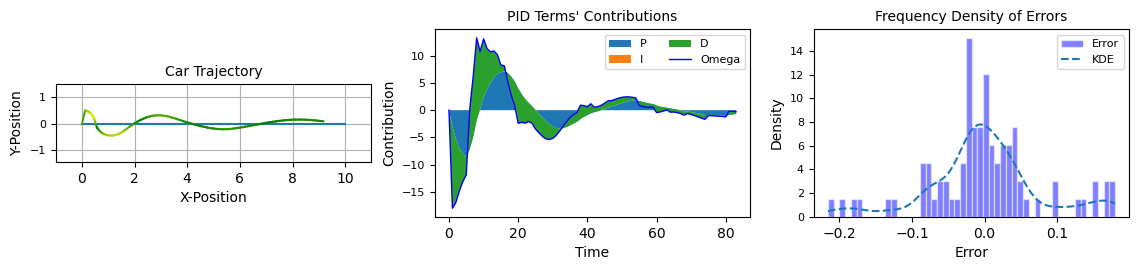

In [20]:

PID(kp=40, kd=200, ki=0, total_distance=10, velocity=1.2, track_init=(0, 0, 0), car_init=(0,0.5,0))